# Machine Learning in Python - Project 1

Friday, March 18th

*Anoushka Ghosh, Keith Tung, Jonathan Hoover, Rebekah Kiner*

## 0. Setup

In [1]:
##packages we installed
##for transcripts of the office episodes
##needed for our plots assessing feature importance
##needed for Random Forest feature importance
##for dropping correlated features
!pip install schrutepy 
!pip install shap 
!pip install feature-engine 


In [2]:
import os

In [3]:
#os library version
from pathlib import Path

# Data libraries
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn modules
import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


from collections import Counter
from sklearn.neighbors import KNeighborsClassifier as KNN
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from feature_engine.selection import DropCorrelatedFeatures
from scipy.stats import shapiro
from IPython.core.display import display_html
import warnings

# extra modules
from schrutepy import schrutepy
import shap

##suppress warnings for pdf
warnings.filterwarnings("ignore")

In [4]:
##Global variables
P = 0.005 ##Threshold total line percentage for being a "main character"
SEED=58 ##SEED threshold for generating test data

To begin, upload the the csv file containg the office data set and then read in the office csv and load the transcript data. Create a copy of the dataframe so that the original data is not overwritten. 

## 1. Introduction
NBC Universal has decided to produce the highly anticipated reunion episode of The Office. However, they are in need of insight of how to best produce the highest rated reunion episode possible. To assist NBC in this, we need to make an interpretable and predictive model that captures the underlying relationships between the features and the audience ratings for The Office.  From this model, we will be able to advise NBC on features to include in the reunion episode that causes high ratings.

Data used to find these features were theoffice.csv and the show’s text transcripts. The additional data sourced from the text transcripts for all the episodes in the show were downloaded from ‘schruptepy.’ The features from the transcripts included in our dataset were: 
* `season` - Season number of the episode 
* `episode` - Episode number within a season 
* `episode_name` - Episode name 
* `director` - Episode director(s) 
* `writer` - Episode writer(s) 
* `character` - Character who have spoken the corresponding lines 
* `text` - Dialogues delivered by the corresponding characters 
* `text_w_direction` - Dialogues delivered in a stage direction 
* `season_episode` - Episode writer(s)

Before looking at models, some Data Cleaning and Data Exploration on the complete dataset was needed to learn more about our features and their relationship to the IMDb ratings. We also take into consideration the interaction between the main characters as features. To produce a model, we need to make sure the data is suitable and the features being used in the model appear to have some predictive power on the ratings.

Then, we fit different models for our data to check which one is the best predictive model. We examined the models of K-Nearest Neighbors Regression, Lasso Regression, Ridge Regression, and Random Forest Regression.

The model that worked best was Random Forest Regression with main character interactions, with $R^{2}$ score around 0.46-0.48 and Root Mean squared error around 0.356. The features that turn out to be a significant influence on the model, consist mostly of characters, some character interactions, some writers, directors, and the number of words and lines.

## 2. Exploratory Data Analysis and Feature Engineering


In [5]:
##Read the office csv and download the office transcripts
d = pd.read_csv("the_office.csv") ##imdb
transcripts = schrutepy.load_schrute() ##transcript data

In [6]:
#copying the data into a new dataframe, so we don't overwrite the original data
df = d.copy()

### *Data Cleaning*
Looking at the director's names, we noticed that some of the directors' name occured twice because of mispellings in their names.  We fixed this prior to any analysis. The mispelled directors corrected are: 
 - Greg Daneils to Greg Daniels
 - Charles McDougal to Charles McDougall
 - Claire Scanlong to Claire Scanlon


In [7]:
##Note that some directors are repeated with different spellings. 
##Fixing the spellings before any future data solutions
wrongdir_dict = {"Greg Daneils": "Greg Daniels", "Charles McDougal": "Charles McDougall",
                 "Claire Scanlong":"Claire Scanlon"}
df["director"].replace(wrongdir_dict, inplace=True)

In [8]:
%%capture
#description of our data
df.info() 

The data has 185 entries/rows and 13 columns in total, without any missing values.
Our features/columns for The Office  data consists of 

| Col# |  Column        |Non-Null Count | Dtype | Description|
|---|  ------        |-------------- | ----- | -----------|
| 0 |  season        |186 non-null   | int64 | season|
| 1 |  episode       |186 non-null   | int64 | episode number|
| 2 |  episode_name  |186 non-null   | object| episode names|
| 3 |  director      |186 non-null   | object| directors|
| 4 |  writer        |186 non-null   | object| writers|
| 5 |  imdb_rating   |186 non-null   |float64| IMDB ratings of each episode|
| 6 |  total_votes   |186 non-null   | int64 | total votes of each episode
| 7 |  air_date      |186 non-null   | object| air date of each episode|
| 8 |  n_lines       |186 non-null   | int64 | number of lines in each episode|
| 9 |  n_directions  |186 non-null   | int64 | number of lines in a stage direction|
| 10|  n_words       |186 non-null   | int64 | number of words in each episode|
| 11|  n_speak_char  |186 non-null   | int64 | number of different characters with spoken lines in episode|
| 12|  main_chars    |186 non-null   | object| main characters appearing in episode

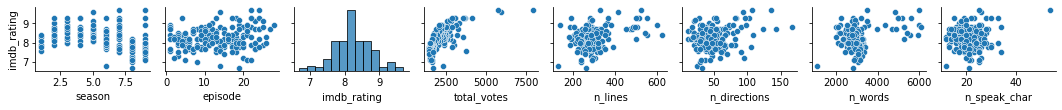

In [9]:
#checking correlations between features (just for imdb_rating)
sns.pairplot(df, height=1.5, aspect=1.25, y_vars = "imdb_rating")

We have created a pairplot looking only at the relationship between the variables and IMDB rating.

The plot suggests that IMDB rating follows a normal distribution. The columns season, total votes, episode variables show some potential as predictors in our initial exploration (we drop these later; see Feature Engineering for reasons). 

We decided to show only the pairsplots comparing the variables to IMDB rating (instead of each variable comparison) because the remaining comparisons did not factor into our model creation. Note that there is a slight correlation between n_words and n_lines (which makes sense since number of lines are dependant on the number of words spoken), but dropping n_words did not improve the model performance, so we kept both n_words and n_lines.

In the pairplot above IMDb ratings look normally distributed. To confirm we will run a Shapiro-Wilk test, which tests a null hypothesis that the data comes from a normal distribution against the alternative that it does not come from a normal distribution.

In [10]:
#some more testing to check for normality
stat, p = shapiro(df["imdb_rating"])
print('Shapiro-Wilk Test statistic:',round(stat,3),'p-value:',round(p,3))

#since p value is not less than alpha=0.05,
#we fail to reject the null hypothesis,i.e data is normal

Shapiro-Wilk Test statistic: 0.988 p-value: 0.12


The Shapiro Wilk test suggests the IMDb ratings data is normal, since the p-value is not less than $\alpha = 0.05$. Thus, we fail to reject the null hypothesis, which says the data follows a normal distribution. This conclusion lets us consider traditional regression models for our prediction (however, we do not end up using the traditional regressions for different reasons; see the Model Fitting and Tuning Section for more details).

We assume that writers and directors have a strong influence on the ratings of an episode. Given this, we've looked at the distribution of both writers and directors along with the highest rated (and lowest) writers and directors throughout the show.

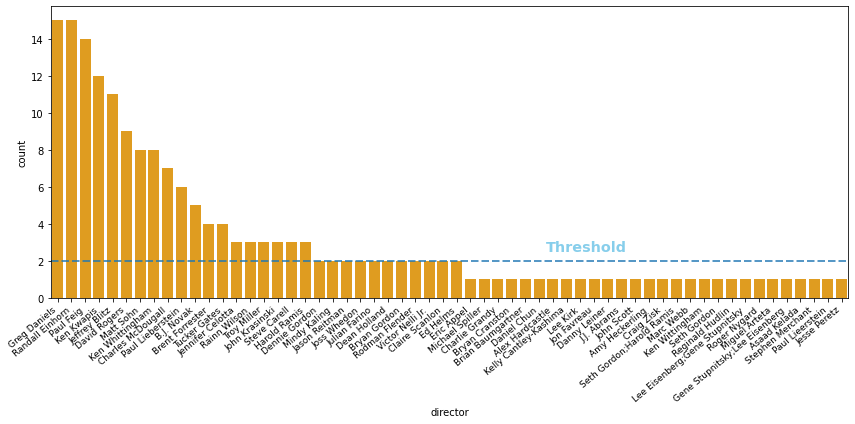

In [11]:
#gets the unique directors and writers in the data
directors = df["director"]


#counts the number of episodes directors have directed and writers directors
plt.figure(figsize=(12,6))

ax1 = sns.countplot(directors, order = directors.value_counts().index, color = "orange")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right",fontsize=9)
ax1.axhline(2, dashes=(5, 2))
plt.text(35.5, 2.5, "Threshold", horizontalalignment='left', size='x-large', color='skyblue', weight='semibold')
plt.tight_layout()


<function matplotlib.pyplot.show(close=None, block=None)>

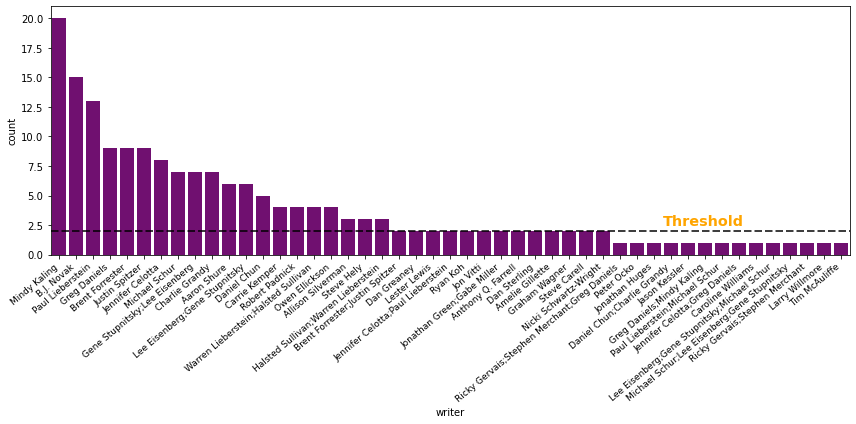

In [12]:
##Writers
writers = df["writer"]

plt.figure(figsize = (12,6))
ax2 = sns.countplot(writers, order = writers.value_counts().index, color = "purple")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right",fontsize=9)
ax2.axhline(2, dashes=(5, 2), color = "black")
plt.text(35.5, 2.5, "Threshold", horizontalalignment='left', size='x-large', color='orange', weight='semibold')
plt.tight_layout()
plt.show

The first barplot displays how many episodes a director directed. The main directors who have directed more than 6 episodes are:
<br>
-Ken Kwapis        $\;\;\;\;\;\;$   -Ken Whittingham
$\;\;\;\;\;\;\;$ -Greg Daniels         <br>-Paul Feig
$\;\;\;\;\;\;\;\;\;$-Charles McDougall   $\;\;\;\;\;$ -   Randall Einhorn
<br>-Jeffrey Blitz    $\;\;\;\;\;\;$    -David Rogers
$\;\;\;\;\;\;\;\;\;\;\;\;$-Matt Sohn

The second barplot displays how many episodes each writer has written. The main writers who have written more than 10 episodes are 
<br>-B.J.Novak, 
<br>-Paul Lieberstein and 
<br>-Mindy Kaling.

Since there are a lot of directors and writers for this show, we want to reduce the number of features to consider. We assume those directors and writers with few appearances will have low impacts on IMDB rating predictions, so we will want to drop the low appearance writers and directors during feature selection. We've set a threshold of 2 episodes, below which we will drop. This threshold is shown on the plots. For more info, read the feature engineering section.


In [13]:

# Get the count of each director for every episode
value_count_director = df['director'].value_counts()

# Select the values of directors where the count is less than 3
to_remove_director = value_count_director[value_count_director <= 2].index

# select rows where the director column is not in to_remove_director
#and save into a new dataframe
df_director = df[~df.director.isin(to_remove_director)]

#grouping the directors with their average imdb rating
directors_avg_rating = df_director.groupby("director")['imdb_rating'].mean().reset_index()

#directors with highest average imdb_rating
best_directors= directors_avg_rating.sort_values("imdb_rating",ascending= False).head(5)
best_directors= best_directors.style.set_table_attributes("style='display:inline'").set_caption('Highest Rated Directors')

#directors with lowest average imdb_rating
bad_directors= directors_avg_rating.sort_values("imdb_rating").head(5)
bad_directors= bad_directors.style.set_table_attributes("style='display:inline'").set_caption('Lowest Rated Directors')

In [14]:
# Get the count of each writer 
value_count_writer = df['writer'].value_counts()

# Select the values where the count is less than 3
to_remove_writer = value_count_writer[value_count_writer <= 2].index

# Keep rows where the writer column is not in to_remove_writer
#and save it to a new dataframe
df_writer = df[~df.writer.isin(to_remove_writer)]


#grouping the writers by their average imdb_rating
writers_avg_rating = df_writer.groupby("writer")['imdb_rating'].mean().reset_index()

#writers with highest average imdb_rating
best_writers= writers_avg_rating.sort_values("imdb_rating",ascending= False).head(5)
best_writers= best_writers.style.set_table_attributes("style='display:inline'").set_caption('Highest Rated Writers')

#writers with lowest average imdb_rating
bad_writers= writers_avg_rating.sort_values("imdb_rating",ascending= True).head(5)
bad_writers= bad_writers.style.set_table_attributes("style='display:inline'").set_caption('Lowest Rated Writers')

We are interested in which writers and directors might have the most predictive value for IMDB rating. As such, we look at which directors got the highest and lowest average IMDb ratings to explore if there is a relationship between writers/directors and IMDb rating. 

In [15]:
##Displaying higest and lowest ratings per episode for directors
display_html(best_directors._repr_html_()+bad_directors._repr_html_(), raw=True)

,director,imdb_rating
5,Harold Ramis,8.866667
16,Steve Carell,8.733333
12,Paul Feig,8.685714
18,Tucker Gates,8.625000
9,Ken Kwapis,8.541667
,director,imdb_rating
8,John Krasinski,7.633333
11,Matt Sohn,7.850000
14,Rainn Wilson,7.933333
1,Brent Forrester,7.950000


In [16]:
##Displaying higest and lowest ratings per episode for writers
display_html(best_writers._repr_html_()+bad_writers._repr_html_(), raw=True)

,writer,imdb_rating
8,Greg Daniels,8.744444
7,Gene Stupnitsky;Lee Eisenberg,8.514286
13,Michael Schur,8.485714
16,Paul Lieberstein,8.400000
2,B.J. Novak,8.373333
,writer,imdb_rating
1,Allison Silverman,7.433333
15,Owen Ellickson,7.450000
18,Steve Hely,7.600000
4,Carrie Kemper,7.825000


The writers and directors with highest average IMDb rating could indicate whom we should hire for the reuinion episode. Conversely, those with the lowest average scores will probably be avoided. The results will depend on the final model.

In [17]:
%%capture
#the categorical columns of the data 
object_col = df.columns[d.dtypes == "object"].tolist()
object_col

Categorical variables will need to be turned into dummy variables.
The Categorical Variables are (5):
<br>
-episode_name $\;\;\;\;\;\;$   -director
<br> -main_chars $\;\;\;\;\;\;\;\;\;\;$ -air_date
<br>-writer

Some episodes have multiple writers and directors. Here we check how many episodes have more than one director or writer. We will need to handle this in the feature engineering section.

In [18]:
print( "Director cells with more than 1 element:",sum([len(x) > 1 for x in d.director.apply(lambda x:x.split(";"))]))
print( "Writer cells with more than 1 element:",sum([len(x) > 1 for x in d.writer.apply(lambda x:x.split(";"))]))

Director cells with more than 1 element: 3
Writer cells with more than 1 element: 34


When looking through the episode names, we identified some episodes that are multi-part episodes. However, some of the two-part episode names are stored as "Parts 1&2" while some are stored seperately as "Part 1" and "Part 2". These will have to be handled in feature engineering. 



In [19]:
##Identifying episodes that are multi-parts
p = re.compile("Part[s| ]")
df[[not pd.isnull(re.search(p,i)) for i in df["episode_name"]]].iloc[[0,1,10],0:4]

,season,episode,episode_name,director
37,3,10,A Benihana Christmas (Parts 1&2),Harold Ramis
50,3,24,The Job (Parts 1&2),Ken Kwapis
79,5,17,Lecture Circuit (Part 2),Ken Kwapis


In [20]:
%%capture
#numerical columns
df.select_dtypes(include=np.number).columns.tolist()

Numerical columns will need to be scaled for a machine learning model. We found the following numerical columns in the dataset:
<br>
-season $\;\;\;\;\;\;\;\;\;\;\;\;$-episode $\;\;\;\;\;\;$-imdb_rating
<br> -total_votes$\;\;\;\;\;\;\;\;$-n_lines$\;\;\;\;\;\;\;\;$-n_directions
<br>-n_speak_char$\;\;\;\;$ -n_words

We are interested in the effect of character lines per episode on IMDb rating (as well as character presence in episode), but this data is not included in the Kaggle dataset provided. Fortunately the schrutepy package contains the transcripts for each episode, so we will mine the transcripts for the total number of characters per line to do some initial exploratory data analysis.

Note that technically this data mining is considered feature engineering, so it could go in the following section; however, to do any exploratory data analysis we need to include it here.

In [21]:
##Feature engineering on transcript data to add to total dataset

##string cols
str_cols = (transcripts.applymap(type) == str).all(0)

##Lower names, character's and lines for easier processing
transcripts = transcripts.applymap(lambda s: s.lower() if type(s) == str else s)

##Remove spaces in character (some are incorrectly written like "jim ")
transcripts['character'] = transcripts['character'].str.replace(" ", "")
transcripts['season_ep'] = transcripts['season'].astype(str) + "_" + transcripts['episode'].astype(str)

# ##Per Episode Character lines
# transcripts.character.unique()
line_sum = transcripts.groupby(["season_ep", "character"]).size().reset_index(name = "lines") ##per character and episode lines
line_sum = line_sum.sort_values(ascending = False, by = "lines")##sort by lines

##Total line percentage per character
line_perc = line_sum.groupby("character").agg({"lines": "sum"}).sort_values(ascending = False, by = "lines")
line_perc['percentage'] = line_perc/(line_perc.sum())

##Greater than P% line share (P defined at the beginning of the notebook; set as 0.005)
main_char = line_perc.loc[line_perc['percentage'] > P].index

##per episode lines for main characters
line_main = line_sum.loc[line_sum['character'].isin(main_char)]

The transcripts contain all speaking characters that appear in the show. However, some characters appear very few times throughout the series. Given that the total number of episodes is 186, we do not need the data from each individual character. This would likely lead to overfitting. As such, we needed to define a threshold for characters to include. We will call these characters the main characters.

To define the main characters we 1) calculate the total number of lines spoken by each character throughout the whole series, 2) Find the percentage of the total lines spoken throughout the series for each character, and 3) set a threshold beyond which a character is considered a main character. In this case, we have set the threshold to 0.005 (0.5% of total lines spoken).


The main characters we then get are :

Character names | Character Names
-------------------|------------------
Micheal       | Jim
Pam      | Dwight
Andy       | Ryan
Jan      | Holly
Angela       | Erin
Darryl     | David
Nellie       | Karen
Robert    | Oscar
Toby       | Meredith
Kevin      | Gabe
Stanley       | Kelly
Phyllis     | Creed

We would imagine that character lines per episode might play a role in IMDb rating. We have plotted this below.

Text(0.5, 1.0, 'Main Character Lines Per Episode')

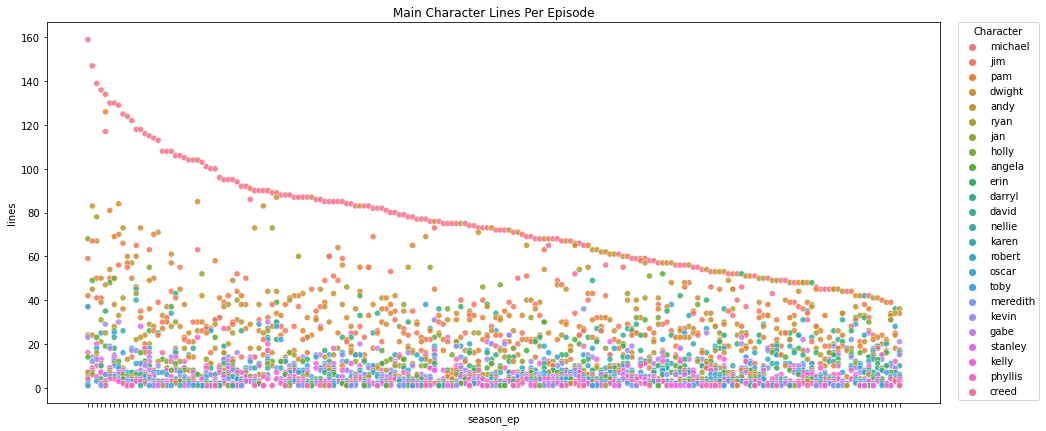

In [22]:
##Plotting episode by total lines for each main character
plt.figure(figsize=(16, 7))
#ax4= sns.lineplot(x = "season_ep", y = "lines", hue = "character", data = line_main)
ax4= sns.scatterplot(x = "season_ep", y = "lines", hue = "character", data = line_main, alpha = .85)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=40, ha="right",fontsize=8)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = "Character")

plt.title("Main Character Lines Per Episode")

It is clear that certain characters dominate each episode (Particularly michael, jim, and dwight), but the patterns change over time. Interestingly, the total number of lines per episode declines over time, which, according to the pair plots above, might be correlated with IMDb rating. 

We would, however, like to see if there is any correlation between total lines per character and IMDb rating. To assess this, we have merged line data with the IMDb data and plotted lines vs IMDb rating (grouped by main character).



<Figure size 1080x504 with 0 Axes>

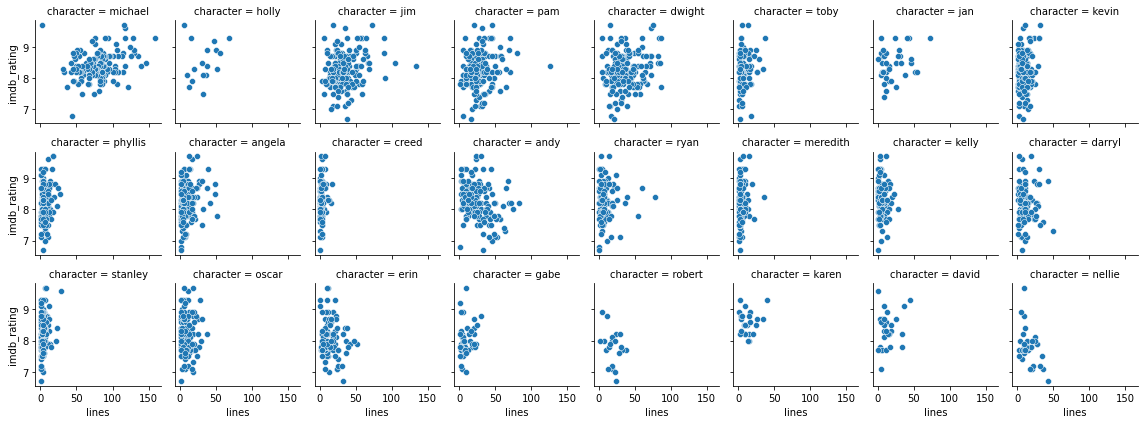

In [23]:
##create season_ep column for d to join by
df['season_ep'] = df['season'].astype(str) + "_" + df['episode'].astype(str)

##merge df imdb rating with lines
lines_imdb = pd.merge(line_main, df[["season_ep", "imdb_rating"]], on = "season_ep")

##make scatterplot of lines vs imdb_rating colored by character
plt.figure(figsize=(15, 7))
ax5= sns.FacetGrid(col = "character", col_wrap=8, data = lines_imdb, height = 2)
ax5.map_dataframe(sns.scatterplot, x="lines", y="imdb_rating")
plt.show()

While not all of the main character's lines appear to have an association with rating, it is clear that some do. In particular, the lines for Michael, Holly, Jim, Pam, and Dwight appear to show some correlation with IMDb rating, so these will likely be good predictors in an ML model.

Note that we have also calculated each characters' percentage of lines per episode and presence per episode (at least one line) for downstream machine learning. These features might be correlated with lines, but they do tell a slightly different story, so they have been included. The plots are not shown here.

In [24]:
##Join main data with lines per character data

##convert line data into dataframe with each row as a season/episode and each column as the main character lines
char_lines = line_main.pivot_table(values='lines', index='season_ep', columns='character').reset_index()
char_lines = char_lines.fillna(0) ##fill NA values with zero because they are only not present if no lines were spoken

##calculate character line percentage per episode
perc_cols = char_lines.select_dtypes(include=np.number).columns + "_perc" ##create column names
char_lines[perc_cols] = char_lines.select_dtypes(include=np.number).div(d.n_lines, axis = 0) ##per row char line percentages

##Create character dummy variables for if present
main_char_dummy = [str(x) + "_dummy" for x in main_char]
char_lines[main_char_dummy] = (char_lines[main_char] > 0).astype(int)

##join the main data with the lines per character data
df = pd.merge(df, char_lines, on = 'season_ep', how = 'left')

### *Feature Engineering*
A critical component to any machine learning analysis is Feature Engineering. Features define the model, so any transformations, additions, or reductions we perform on the feature space will affect the final model performance. 

Given the exploratory data analysis, it is clear that we need to transform the writer and director columns into a categorical variable type that a machine learning model can handle. As noted before, some writers and directors have the names paired together with ";". We could either separate them or treat each unique combination as it's own category. We decided to treat each as its own category and create dummy variables that identify the combination of directors or writers present in an episode.

We will use one-hot encoding where each unique level of the categorical variable (minus one to ensure rank is sufficient) is given it's own binary column defining if that level is present of not. We use the pandas function get_dummies to do so.

Note that we defined the main characters as dummy variables above with the transcript data.

In [25]:
%%capture
##Replace any spaces in column names with "_"
df.columns = df.columns.str.replace(' ', '_')

##Want to get a list of all writers and a list of all directors 
##Create new columns where the presence of each writer is it's own variable (one-hot encoding)

df = pd.get_dummies(df, columns=['writer', 'director']) ##contains multiple director combinations
df.filter(regex = "writer_|director_").head()

As we found in the exploratory data section, there are many writers and directors that appear only once or twice throughout the entire show. These columns do not add much information and only make the data more complex, so we combine these writers and directors into a new column called "low_appearance_writers" (or directors) and drop the original columns, as displayed below. This column is a dummy variable that defines when at least one of these low appearance writers or directors is present in the data. 

As mentioned before the threshold for a "low_appearance" writer or director is one that appears in 1 or 2 episodes.

In [26]:
##Function to group "low" appearance directors/writers into one "low-appearance" column dummy variable
##Removes the original columns for those low-appearane writers directors
def categorize_low(column_type, df, threshold):
    ##if writer/director shows up less than or equal to the threshold, re-categorize to "Low-Appearance"
    items_eps = df.sum(axis = 0)
    low_appearance = list(items_eps[items_eps <= threshold].index) 
    new_col = "low_appearance" + "_" + column_type

    ##create new writer column for low-appearance
    df_new = df.copy()
    df_new[new_col] = df_new[low_appearance].sum(axis = 1) > 0 ##Identifies episodes where a low_appearance writer/dir is
    df_new[new_col] = df_new[new_col].astype(int) ##convert boolean to integer
    
    ##drop original low_appearance columns
    df_new.drop(columns = low_appearance, inplace = True)
    
    return(df_new)


##group low-appearance writers and remove columns for those low-appearance writers/directors
writers_df = df.filter(regex = "writer_") ##get dummy writer data
writers_df_cols = writers_df.columns ##get column names for dummy writer data
writers_df = categorize_low(column_type = "writer", df = writers_df, threshold = 2) ##combine low-appearance into one col

##group low-appearance directors and remove columns for those low-appearance writers/directors
directors_df = df.filter(regex = "director_") ##get dummy director data
directors_df_cols = directors_df.columns ##get column names for dummy directors
directors_df = categorize_low(column_type = "director", df = directors_df, threshold = 2) ##combine low appearance into col


##Add the writer and director data to overall data
writer_director_col = list(writers_df_cols) + list(directors_df_cols)
df = pd.concat([df.drop(columns = writer_director_col), writers_df, directors_df], axis = 1)

df.filter(regex = "low_appearance").head()

,low_appearance_writer,low_appearance_director
0,1,0
1,0,0
2,0,0
3,0,1
4,0,0


As mentioned before, there are some two-part episodes. We created a column called "multi_part" to label these episodes as multi_part episodes with the expectation that they might yield different IMDb ratings since they are a unique episode type.

However, we also noted before that some of the two-part episode names are stored as "Parts 1&2" while some are stored seperately as "Part 1" and "Part 2". This could potentially cause bad IMDb predictions. Since separating is not an option, we decided to drop the observations for the two-part episodes labeled with "Parts 1&2". There are only two observations like this, so dropping should not have much impact.

In [27]:
##Create multipart episode columns

# Create column to indicate if said episode consist of multi parts
p = re.compile("Parts 1&2")
df["multi_part"] = [int(not int(pd.isnull(re.search(p,i)))) for i in df["episode_name"]]


##Drop the observations of the separated multi-part episode and create a new filtered dataframe
p        = re.compile("Part [12]") ##regex to find part 1 or part 2 not both
row_keep = [pd.isnull(re.search(p,i)) for i in df["episode_name"]] ##dropping the separated multi_part episodes by keeping the others
fdat = df.iloc[row_keep,:]##drop

In addition to the transformations and feature additions we performed above, there are some features we must remove. There are three categories for removal: 1) The data is not available before an episode is aired (and therefore cannot be used to predict). 2) The data will lack predictive power, and 3) The data is reflected in other columns.

Total votes falls into the first category. Total votes is the total number of IMDb votes for the episode, which will not be available before airing. Thus total votes is removed. 

Season, season_ep, episode, episode_name, and air_date fall into the second category. Season, episode, and air_date will be known for new episodes, but the new episodes will have values for these features not contained within the training data, so they won't have predictive value. Thus, we drop these columns.

Episode name alone is not likely to have any predictive value. It might be correlated with episode content, which would have predictive value, but any prediction from it would not be interpretable, so we drop this feature as well. 

Lastly, main_characters (the main characters provided in the original data) falls into the third category. We created variables for main character lines, line percentage, and presence during the feature addition phase, so the original main characters feature is redundant and thus dropped. 

In [28]:
# remove unused columns and observations
col_drop = ["season","episode_name", "total_votes", "season_ep", "air_date", "episode", "main_chars"]

##Update filtered data with columns dropped
fdat = fdat.drop(col_drop,axis=1)

In [29]:
##save raw and filtered data

##create data directory if it doesn't exist
if not os.path.exists("./data"): os.mkdir("./data")

# %%
df.to_csv("data/full_raw_dat.csv", index=False)
fdat.to_csv("data/full_filtered_dat.csv", index=False)

Next, we want to consider some interactions of our features.  We cannot consider every interaction for all our features since it would yield over 7000 features and our dataset only has 184 observations (after removing 2 multi-part episodes). Thus, we only consider interactions between character lines since viewers enjoy some character combinations more than others so these interactions have the potential for predictive power. The model should detect which of the interactions are most important for IMDB ratings.

In [30]:
##Now we want to find the interactions between any data we've kept EXCEPT categorical data
##Categorical data is mostly zeros, so any interaction will not be helpful
df_int = fdat

interactions = PolynomialFeatures(interaction_only=True, include_bias=False)  ##load feature builder

##create pipeline for interaction creation
interaction_pipe = Pipeline([
    ("interactions", interactions),
])


##define columns we wish to find interactions for
##Since this is a small dataset, we don't want to create too many features
##As such, only doing interactions between character lines, since these make sense for episode performance

interaction_cols = main_char.to_list() ##main_char defined above. Using as the cols for interactions
char_interactions = interaction_pipe.fit_transform(fdat[interaction_cols], fdat["imdb_rating"])

#get new names of the interaction featurs
inter_features = interaction_pipe.named_steps['interactions'].get_feature_names_out(list(interaction_cols))

##Dataframe with interactions 
interaction_df = pd.DataFrame(char_interactions, columns = inter_features)
interaction_df.columns = interaction_df.columns.str.replace(' ', ':')

interaction_df = interaction_df.drop(columns = interaction_cols)
df_int = pd.concat([fdat.reset_index(drop = True), interaction_df], axis = 1)
df_int.to_csv("data/Interactions.csv", index = False)
fdat = df_int

### *Standardisation of the data*


The last feature engineering step is to standardize the numeric columns. Standardization is a critical step when the support of the individual features is different (https://medium.com/@urvashilluniyawhy-data-normalization-is-necessary-for-machine-learning-models-681b65a05029). This is important for regression models since the model requires differentiation and gradient calculation. This insures the model is optimized and coefficients converge since the features are all in the same range. 

The standardization is applied only to the predictor variables (not response). However, the standardization is purely based on the training set mean divided by the standard deviation to ensure we do not overfit the test data. 

Both a training set and a test set standardized by the training set values are created. In these datasets we split the response variable from the predictors (X from y) and then split both X and y into training and test sets with a 80/20 split (training/test).

In [31]:

# separate response and explanatory data
X = fdat.drop("imdb_rating", axis=1)
y = fdat.imdb_rating

# write raw files
##make new file
Path(f"./data/SEED_{SEED}").mkdir(parents=True, exist_ok=True)

##split data into train test (No need to do a stratified split because we are doing a regression)
##Numerical data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [32]:
##Write to csvs for later

##numerical data
X_train.to_csv(f"data/SEED_{SEED}/X_train_raw.csv", index=False)
X_test.to_csv(f"data/SEED_{SEED}/X_test_raw.csv", index=False)
y_train.to_csv(f"data/SEED_{SEED}/y_train.csv", index=False)
y_test.to_csv(f"data/SEED_{SEED}/y_test.csv", index=False)

# create pipeline for scalers
std_scale = Pipeline([('standard', StandardScaler())]) ##standardized scaling

#select columns that require scaling
##First we select all numeric variables, but these contain dummy variables, which we do not want to scall
##So then we identify dummy variables (All dummies are numeric, but binary)
##and select from numerics, if NOT a dummy variable

scale_col = X_train.select_dtypes(include = np.number) ##subset the numeric columns
cat_cols = scale_col.filter(regex = 'dummy|writer|director').columns ##subset the columns with dummy/writer/director

scale_col = [col for col in scale_col if col not in cat_cols] ##update scale_col with numeric columns not in dummy vars

##Define column transformers for scaling 
std_prep = ColumnTransformer(
        remainder='passthrough', ##keep all columns not specified in transformer
        transformers=[
            ('std', std_scale , scale_col), ##apply std_scale to scale_col
        ])

##fit scaler on training data
std_prep.fit(X_train) ##fit to the training data
std_train = pd.DataFrame(std_prep.transform(X_train), columns = X_train.columns) ##turn into a dataframe with correct cols
std_test = pd.DataFrame(std_prep.transform(X_test), columns = X_train.columns) ##Transform test data with fit from training 

##write to csv
std_train.to_csv(f"data/SEED_{SEED}/X_train_std.csv", index=False)
std_test.to_csv(f"data/SEED_{SEED}/X_test_std.csv", index=False)

*Feature Reduction Side Note:*

We attempted to reduce the feature set by removing highly correlated features; however, all resulting models had worse evaluation metrics (root mean-squared error, $R^{2}$ for regressors and F score, precision, and recall for classifiers). As such that analysis is not included.

# 3. Model Fitting and Tuning
### *Chosen Model: Random Forest*

We would like a model that is highly interpretable and can inform the choices for a reunion episode of the office. Our response variable, IMDb rating, is continuous and normally distributed, so a regression approach (instead of classification) is the most viable option. 

Our dataset contains more features than observations with 184 observations and 394 features (after dummy variables and interactions are created and before splitting into training and test sets). The training set (80% of data) has 147 observations and 394 features. Traditional linear regressions ML models are highly interpretable; however, they struggle with datasets containing more features than observations, so we need a regression approach that can handle this data structure and is still interpretable.

Random Forest regressors are a non-parametric, ensemble decision-tree method for regression that work well with datasets containing more features than observations [1, https://www.tandfonline.com/doi/pdf/10.1198/tast.2009.08199?needAccess=true]. Additionally, this model can easily find the features that define the splits in the forest, which lends itself to an interpretable model. 
 
After analyzing many different models, we have decided on the Random Forest model as it provided the best results and is interpretable. These results will be discussed in following sections. 
 
 ### *Random Forest Background* 
 
Before getting into the details of our analysis, it is important to understand what random forests are and how they yield regression results. 
 
Random Forests are a collection of trees built such that each tree contains a bootstrapped subsample of the data. Each tree contains only a subset of the total features, which reduces correlation in the trees. By reducing the total correlation, we reduce the effects of sampling error that would be present in a single tree.
 
Within each tree, the algorithm searches through the features to identify which is "most important" for splitting the data at a given node. In the scikit-learn package, the feature importance is defined by the gini importance, which calculates the mean decrease in impurity for each feature and selects the feature that will decrease the impurity the most at a given node (See [https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3] for more information). **So the higher the gini importance, the better the split**. This gini importance index will be important for identifying the features most likely to give a higher IMDb rating in a reunion episode. 

For a random forest, the prediction is made by dropping the new observation into each tree of the forest, finding the predicted value for each tree, and averaging the values of each tree in the forest. 

It is our hope that the Random Forest algorithm's ability to perform well on high feature, low observation data (while yielding feature information data), will help us identify features that are likely to yield a well-rated reunion episode.

### *Model Tuning*

We performed a cross-validated grid search (5-fold) on the following parameters in sklearn's RandomForestRegressor algorithm: n_estimator, min_impurity_decrease, min_samples_leaf, and max_depth to find the optimal parameters for our model. The optimal random forest based on the grid search is a random forest with 280 trees, a max of 7 nodes per tree, a minimum of 1 sample per terminal node, and a minimal impurity decrease of 0 (no minimum).

The true response vs predicted values and residuals plots from the test set are shown below.

In [33]:
##The following functions were defined in workshop 5 (of the course) for regression analysis
##We have just copied here

def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': list(y) - y_hat}
    )

    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse


In [34]:
##We have commented the grid search out for you so the code runs faster
##feel free to uncomment to run

##Chosen Model: Random Forest Regression

##Performing Grid Search to identify the best tuning parameters for
##The number of trees in the forest and the minimum samples required for a tree

# RF = RandomForestRegressor(max_features = "sqrt", random_state = 22, max_depth = 5)
# RF_pipe = Pipeline([("RF", RF)])
# grid_params_rf = {
#     "RF__n_estimators": np.arange(100,300, step = 20),
#     "RF__min_samples_leaf": np.arange(1,5),
#     "RF__min_impurity_decrease": np.arange(0,0.3, step = 0.1),
#     "RF__max_depth": np.arange(2, 10, step = 5)
# }

# gs_RF = GridSearchCV(RF_pipe, grid_params_rf, cv=KFold(5, shuffle=True, random_state=32),
#     scoring="neg_root_mean_squared_error"  ##negative because for optimization we need to find the minimum but the default optimizer is a maximizer (so we reverse this)
#                  )
# gs_RF.fit(std_train, y_train)

In [35]:
# ##report the best parameters
# print("Results of 5-Fold Cross Validation Grid Search for Tuning Random Forest Hyperparameters:")
# gs_RF.best_params_

In [36]:
##Feature importances (using best parameters found above)
RF = RandomForestRegressor(max_features = "sqrt", n_estimators = 280, min_samples_leaf = 1, random_state = 22, max_depth = 7)
RF.fit(std_train, y_train) ##fit the regressor to the data

RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=280,
                      random_state=22)

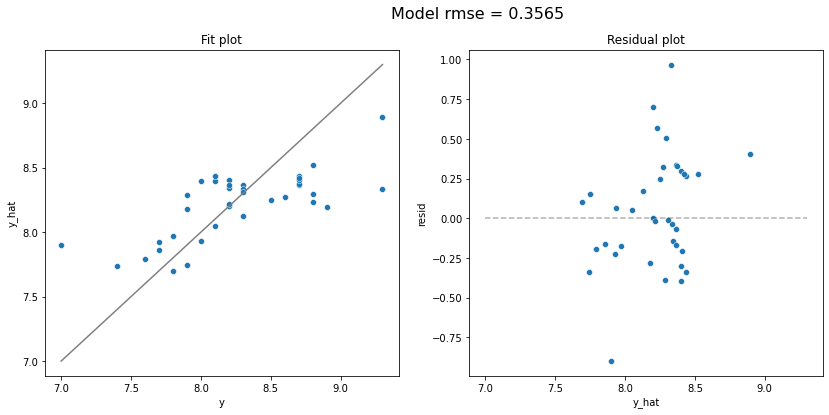

0.35649703404486344

In [37]:
##Plot model fit plots
model_fit(RF, X = std_test, y = y_test, plot = True)

In [38]:
##Train and Test Results
print("Training Set Results:")
print("R^2 Train")
print(r2_score(y_train, RF.predict(std_train)))
print("MSE Train")
print(mean_squared_error(y_train, RF.predict(std_train)))
print("RMSE Train")
print(np.sqrt(mean_squared_error(y_train, RF.predict(std_train))))
print("-------------------------------------------------------------------------")
print("Test Set Results:")
print("R^2 Test")
print(r2_score(y_test, RF.predict(std_test)))
print("MSE Test")
print(mean_squared_error(y_test, RF.predict(std_test)))
print("RMSE Test")
print(np.sqrt(mean_squared_error(y_test, RF.predict(std_test))))

Training Set Results:
R^2 Train
0.8552456786412643
MSE Train
0.04327570743339031
RMSE Train
0.20802814096508748
-------------------------------------------------------------------------
Test Set Results:
R^2 Test
0.479082649095413
MSE Test
0.12709013528278454
RMSE Test
0.35649703404486344


The results above indicate that the RF regressor explains 85.5% of the variation ($R^{2}$ value) in the training data and 47.9% of the variation in the test data. The root mean-squared errors are 0.21 and 0.36 in the training and test set, respectively. The model fits the training set better than the test data; however, the difference between the two is not high enough to be concerned about overfitting. 

The low $R^{2}$ value for the test set actually reflects the nature of the data. IMDb ratings are inherently subjective. They are influenced by the opinions of individuals, so there is intrinsically a high level of variability. As such, we can not expect a simple model to fully capture the variability in a noisy dataset.

While the test data set $R^{2}$ value of 0.479 means the model is not the best predictor, it still is a good model. The residuals show the error is randomly distributed about 0, so there is no association between the predicted IMDb rating and the error. Additionally, the rank of the true high values appears to be correlated with the rank of the predicted y-values (i.e. the highest true values are the highest predicted values even though the prediction is not 100% accurate). Therefore, while the model might not predict well, it is still a good explanatory model to understand the variables that most influence the rating. This will be explored next.

### *Feature Importance*

To identify the important features could look at the gini importance (explained above); however, the gini importance only gives the absolute importance of a feature not the direction of effect. To get direction of effect, we will look at SHAP values. SHAP stands for SHapley Additive ExPlanations, coming from game theory. The SHAP values indicate the difference between the predictive model and the null model. Higher SHAP values are associated with a higher predictive power and lower SHAP values are associated with lower. For more details please see the following article https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

We use SHAP values to identify the direction of effect for a given feature by plotting the SHAP values for each feature and coloring by the value of the feature (plots shown below). 

In the plot below, the x-axis stands for SHAP value. The y-axis has all the features. Each point on the chart indicates a SHAP value for the respective feature.

Negative SHAP values are associated with lower IMDb ratings and positive SHAP values are associated with higher IMDb ratings. Red indicates high values for the feature and blue indicates a lower value for the feature, so if a feature has all red points with positive SHAP values, that feature is positively associated with IMDb ratings. Conversely if all red points are associated with negative SHAP values, the feature is negatively associated with IMDb ratings. 



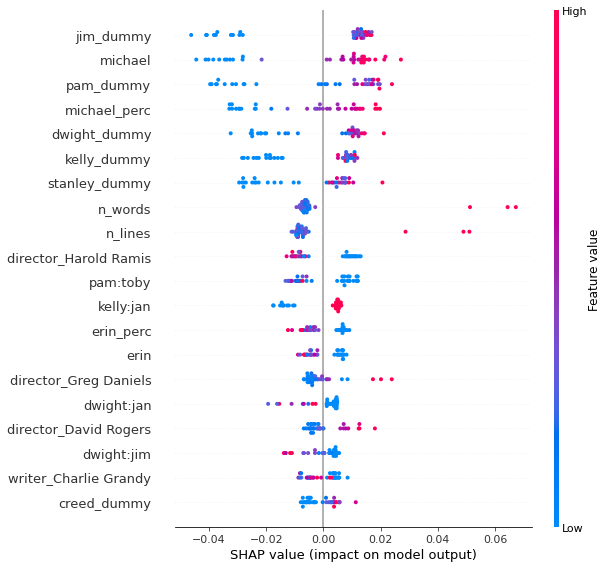

In [39]:
##Test set shap values
shap_values_test = shap.TreeExplainer(RF).shap_values(std_test) ##shap is a metric for feature importance. TreeExplainer also helps get feature info
f = plt.figure(figsize = (15,10))
shap.summary_plot(shap_values_test, std_test, max_display = 20) ##shap summary with direction of effect

The plot above, shows the top 20 features (according to gini importance), our model predicts the following features will have a positive impact on IMDb ratings:
- The presence of Jim, Michael, Pam, Dwight, Kelly, Stanley, and Creed.  
- The character interactions of Kelly & Jan
- A high number of words and lines (including stage direction). 
- The directors Greg Daniels and David Rogers 

Our model predicts the following features will have a notable negative impact on IMDb ratings:
- The character interactions of Pam & Toby, Dwight & Jan, and Dwight & Jim 
- The director Harold Ramis. 
- The writer Charlie Grandy.

Note that these are just the top 20 features. For more nuanced info, we could look at more features, but these 20 are fairly informative.

### *What other models we tried*

#### *K-Nearest Neighbors*
- A brief literature search on algorithms used to predict movie ratings showed KNN ML algorithms used occassionally, so we tried both a KNN regression and classification. Both regression and classification results were poor for all attempts at the algorithm (Regression: $R^{2}$ < 0.25, RMSE > 0.42; Classification: Avg Precision < 0.3, Avg Recall < 0.3 F-metric < 0.2), so we decided against this model. 

#### *Ridge Regression*
- Considering the response variable, IMDb rating, is normally distributed and continuous nature, some form of regression makes sense. Ridge regression is suitable when a dataset contains a higher number of predictor variables, thus tested this model on the data. Ridge regression with an alpha of ~40.703(found using GridSearchCV)  produced poor $R^{2}$ (<0.36) and RMSE results (>0.431) for all attempts, so we discarded it.

#### *LASSO Regression*
- Given the high number of features and low number of observations, we decided to try a LASSO regression in an attempt at feature reduction (Note that if a tuned value of alpha is 0, this yields a traditional regression, so we did not attempt a traditional regression). The LASSO regression results (tuned for an alpha value of 0.05) yielded poor $R^{2}$ (< 0.28) and RMSE (> 0.41) for all attempts, so we decided against the algorithm.

# 4. Discussion & Conclusions

While our Random Forest model is not the best predictive model ($R^{2}$ = 0.479), it clearly identifies key features that influence the IMDb score. From the SHAP plots, it appears that character presence and lines seem to dominate the effect, but also some characters and writers. 

For the characters, Jim, Michael, Pam, Dwight, Kelly, and Stanley seem to be the most important characters in the show. Their presence has the most positive influence the IMDb score, so any reunion episode should these characters. Also, Michael should have a higher number of lines while the others just need to be present.

Additionally, some character interactions appear to be important. The data suggests that a combination of high Kelly and high Jan lines in an episode (not necessarily dialogue with each other) are associated with better IMDb ratings. Jan is not a common character, so this suggests that including Jan (with a high number of lines) might make a better reunion episode. Interestingly, episodes with high Dwight and Jim lines seem to have lower IMDb ratings. Given their individual importance this suggests that a reunion episode should include them but not give them both a high number of lines. 

Lastly, some writers and directors appear to influence the IMDb ratings. Directors Greg Daniels and David Rogers are associated with better ratings while Harold Ramis is associated with lower ratings. The writer Carrie Kemper also appears to be associated with better ratings. These results suggest that NBC producers may wish to hire Greg Daniels or David Rogers as directors and Carrie Kemper as a writer. Interestingly, the exploratory data analysis showed that Harold Ramis had the highest average IMDb rating for his episodes while the model suggests he has a negative impact on IMDb rating. This could either indicate that average score is not a good indicator for IMDb rating or that the model is predicting incorrectly (we do know the model is not perfect).

Given the predictive quality of our model is low, these interpretations may be innaccurate (see Harold Ramis). This model is a great tool to identify potential ingredients for a high quality reunion episode, but it does not capture all of the variability in the data. 

An episode's performance is largely driven by the story, character interactions, non-verbal cues, etc., which cannot be captured in the data we have. We may be able to improve the model with a more complex text analysis of the transcript, like sentiment and tone analysis, but it requires complex NLP analysis not included here. Additionally, viewer's opinions are inherently varied, so an accurate prediction of rating is not particularly expected. 

One last critical note is that the office aired from 2005 to 2013. Societal culture has changed dramatically since then, so any predictions from these models may not accurately reflect the reception in current times. Additionally, many of the current fans have watched most of the show on streaming services instead of TV, so the reunion episode would likely be streamed instead of aired. Thus, a better prediction metric for a reunion episode's success would be views per episode on the streaming platform rather than IMDb rating. 

In conclusion, the best chance at a successful reunion episode is to bring the writers, directors, and characters identified above together to build a story that hopefully resonates with viewers, but without data that more accurately reflects the storyboard and current society's viewing norms, we will not have the best prediction.